In [7]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import string

def generate_synthetic_data(rows=1000, cols=30, seed=42):
    """
    Generates a synthetic DataFrame with mixed data types:
    - Boolean
    - Integer (numeric)
    - Float
    - Text
    - Categorical
    - Date

    Parameters:
    - rows: int, number of rows
    - cols: int, total number of columns

    Returns:
    - df: pd.DataFrame, synthetic dataset
    """
    np.random.seed(seed)
    random.seed(seed)

    col_types = ['bool', 'int', 'float', 'text', 'category', 'date']
    type_counts = {k: cols // len(col_types) for k in col_types}
    remainder = cols % len(col_types)
    for i in range(remainder):
        type_counts[col_types[i]] += 1

    data = {}

    for i in range(type_counts['bool']):
        data[f'bool_col_{i}'] = np.random.choice([True, False], size=rows)

    for i in range(type_counts['int']):
        data[f'int_col_{i}'] = np.random.randint(0, 1000, size=rows)

    for i in range(type_counts['float']):
        data[f'float_col_{i}'] = np.random.uniform(0, 1000, size=rows)

    for i in range(type_counts['text']):
        data[f'text_col_{i}'] = [''.join(random.choices(string.ascii_letters, k=10)) for _ in range(rows)]

    for i in range(type_counts['category']):
        data[f'cat_col_{i}'] = pd.Series(np.random.choice(['A', 'B', 'C', 'D'], size=rows)).astype("category")

    base_date = datetime(2020, 1, 1)
    for i in range(type_counts['date']):
        data[f'date_col_{i}'] = [base_date + timedelta(days=np.random.randint(0, 3650)) for _ in range(rows)]

    data[f'target'] = np.random.uniform(0, 1000, size=rows)

    df = pd.DataFrame(data)
    df['target'] = df['target'].astype(float)
    return df

# Generate and preview
main_df = generate_synthetic_data()
df = main_df.copy()
df.head()

,bool_col_0,bool_col_1,bool_col_2,bool_col_3,bool_col_4,int_col_0,int_col_1,int_col_2,int_col_3,int_col_4,...,cat_col_1,cat_col_2,cat_col_3,cat_col_4,date_col_0,date_col_1,date_col_2,date_col_3,date_col_4,target
0,True,False,True,False,False,946,839,945,801,955,...,C,D,B,B,2025-08-29,2020-05-08,2028-12-02,2025-11-30,2029-12-21,12.137458
1,False,True,False,False,True,686,123,70,588,599,...,A,D,A,A,2027-09-07,2024-01-10,2025-05-17,2026-10-08,2020-09-21,488.643897
2,True,True,False,False,True,750,992,363,809,755,...,C,A,C,C,2025-02-06,2027-04-15,2026-12-04,2028-02-13,2020-11-28,644.205482
3,True,True,False,False,True,771,112,569,648,380,...,C,B,D,C,2025-06-02,2025-09-13,2022-07-10,2026-03-27,2026-02-13,918.191773
4,True,True,False,True,False,902,11,801,617,328,...,B,A,C,D,2024-10-02,2027-11-06,2023-12-01,2029-03-08,2022-12-22,381.335817


In [8]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf

def evaluate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate_correlation(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1]

def evaluate_homoscedasticity(y_true, y_pred):
    residuals = y_true - y_pred
    _, p_value = stats.levene(residuals, y_pred)
    return p_value  # Higher p-value indicates more likely homoscedasticity

def evaluate_autocorrelation(residuals, lags=40):
    plot_acf(residuals, lags=lags)
    plt.title("Autocorrelation of Residuals")
    plt.show()

def percentile_distribution_analysis(y_true, y_pred):
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    df['error'] = df['y_true'] - df['y_pred']
    return df['error'].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])

def variance_analysis(y_true, y_pred):
    residuals = y_true - y_pred
    return {
        'variance_y_true': np.var(y_true),
        'variance_y_pred': np.var(y_pred),
        'variance_residuals': np.var(residuals)
    }

def cross_validation_rmse(model, X, y, cv=5):
    neg_mse = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=cv)
    return np.sqrt(-neg_mse)

In [9]:
def convert_str_to_numeric(df, errors='coerce'):
    """
    Converts columns with strings that look like numbers into numeric dtype.
    `errors='coerce'` will convert invalid parsing to NaN.
    """
    df_converted = df.copy()
    for col in df_converted.columns:
        if df_converted[col].dtype == object:
            try:
                df_converted[col] = pd.to_numeric(df_converted[col], errors=errors)
            except:
                pass
    return df_converted

def lowercase_string_columns(df):
    """
    Lowercases all string (object) column values.
    """
    df_cleaned = df.copy()
    str_cols = df_cleaned.select_dtypes(include='object').columns
    for col in str_cols:
        df_cleaned[col] = df_cleaned[col].astype(str).str.lower().str.strip()
    return df_cleaned

def handle_boolean_columns(df):
    """
    Converts columns with boolean-looking strings or integers into proper bool dtype.
    """
    df_bool = df.copy()
    for col in df_bool.columns:
        if df_bool[col].dtype == object:
            unique_vals = df_bool[col].dropna().astype(str).str.lower().unique()
            if set(unique_vals).issubset({'true', 'false', 'yes', 'no', '1', '0'}):
                df_bool[col] = df_bool[col].astype(str).str.lower().map({
                    'true': True, '1': True, 'yes': True,
                    'false': False, '0': False, 'no': False
                })
        elif df_bool[col].dtype in [int, float] and set(df_bool[col].dropna().unique()).issubset({0, 1}):
            df_bool[col] = df_bool[col].astype(bool)
    return df_bool
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def normalize_minmax(df, columns=None):
    """Applies Min-Max normalization to selected numeric columns."""
    df_norm = df.copy()
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns
    scaler = MinMaxScaler()
    df_norm[columns] = scaler.fit_transform(df_norm[columns])
    return df_norm

def standardize_zscore(df, columns=None):
    """Standardizes selected numeric columns using Z-score (mean=0, std=1)."""
    df_scaled = df.copy()
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    df_scaled[columns] = scaler.fit_transform(df_scaled[columns])
    return df_scaled

def robust_scale(df, columns=None):
    """Applies robust scaling using median and IQR (resistant to outliers)."""
    df_robust = df.copy()
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns
    scaler = RobustScaler()
    df_robust[columns] = scaler.fit_transform(df_robust[columns])
    return df_robust

def log_transform(df, columns=None, add_constant=True):
    """
    Applies log transformation to selected numeric columns.
    - add_constant: Add 1 to avoid log(0) if True.
    """
    df_log = df.copy()
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns
    for col in columns:
        try:
            if add_constant:
                df_log[col] = np.log1p(df_log[col])  # log(1 + x)
            else:
                df_log[col] = np.log(df_log[col])
        except Exception as e:
            print(f"Skipping log transform on {col} due to error: {e}")
    return df_log
def drop_duplicates(df):
    """Remove duplicate rows from the DataFrame."""
    return df.drop_duplicates()

def drop_constant_columns(df):
    """Remove columns with only a single unique value."""
    return df.loc[:, df.apply(lambda col: col.nunique(dropna=False) > 1)]

def drop_columns_by_null_threshold(df, threshold=0.5):
    """
    Drop columns with missing values above the given threshold.
    - threshold (float): Max allowable proportion of nulls (0 to 1).
    """
    null_fraction = df.isnull().mean()
    cols_to_keep = null_fraction[null_fraction <= threshold].index
    return df[cols_to_keep]

def impute_missing_values(df, strategy="mean"):
    """
    Fill missing values in numeric and categorical columns.
    - strategy (str): 'mean', 'median', or 'mode'.
    """
    df_clean = df.copy()
    
    for col in df.columns:
        if df[col].isnull().sum() == 0:
            continue
        
        if pd.api.types.is_numeric_dtype(df[col]):
            if strategy == "mean":
                fill_value = df[col].mean()
            elif strategy == "median":
                fill_value = df[col].median()
            elif strategy == "mode":
                fill_value = df[col].mode()[0]
            else:
                raise ValueError("strategy must be one of: 'mean', 'median', 'mode'")
            df_clean[col] = df[col].fillna(fill_value)
        else:
            # Categorical or text-based column: use mode only
            fill_value = df[col].mode()[0]
            df_clean[col] = df[col].fillna(fill_value)
    
    return df_clean

def strip_whitespace_string_columns(df):
    """Trim whitespace in string or object-type columns."""
    df_clean = df.copy()
    str_cols = df_clean.select_dtypes(include=["object", "string"]).columns
    for col in str_cols:
        df_clean[col] = df_clean[col].astype(str).str.strip()
    return df_clean

numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
date_cols = df.select_dtypes(include=["datetime64"]).columns.tolist()
bool_cols = df.select_dtypes(include=["bool"]).columns.tolist()
all_cols = df.columns.tolist()

df = drop_duplicates(df)
df = drop_constant_columns(df)
df = drop_columns_by_null_threshold(df, threshold=0.4)
df = impute_missing_values(df, strategy="mode")
df = strip_whitespace_string_columns(df)
df = normalize_minmax(df, columns=numeric_cols)
df = standardize_zscore(df, columns=numeric_cols)
df = robust_scale(df, columns=numeric_cols)
df = log_transform(df, columns=numeric_cols, add_constant=True)
# df = log_transform(df, columns=numeric_cols, add_constant=False)
# df = convert_str_to_numeric(df, errors='coerce')
df = convert_str_to_numeric(df, errors='ignore')
# df = convert_str_to_numeric(df, errors='raise')
df = lowercase_string_columns(df)
df = handle_boolean_columns(df)

c:\Users\varun\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\varun\AppData\Local\Temp\ipykernel_12380\2834822608.py:10: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_converted[col] = pd.to_numeric(df_converted[col], errors=errors)


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

def split_regression_data(df, target_col, method="random", test_size=0.2, stratify_bins=10, time_col=None, n_clusters=5, random_state=42):
    """
    Split regression dataset using different strategies: random, stratified, time-based, or cluster-based.

    Parameters:
    - df (pd.DataFrame): Input dataset.
    - target_col (str): Name of the regression target column.
    - method (str): One of ['random', 'stratified', 'time', 'cluster'].
    - test_size (float): Proportion of test set.
    - stratify_bins (int): Number of quantile bins for stratified splitting.
    - time_col (str): Column for time-based split (required for 'time' method).
    - n_clusters (int): Number of clusters for cluster-based split.
    - random_state (int): Random seed for reproducibility.

    Returns:
    - train_df (pd.DataFrame): Training data.
    - test_df (pd.DataFrame): Testing data.
    """
    df = df.dropna(subset=[target_col]).copy()

    if method == "random":
        train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)

    elif method == "stratified":
        # Bin the target column for stratification
        stratify_labels = pd.qcut(df[target_col], q=stratify_bins, duplicates="drop")
        train_df, test_df = train_test_split(df, test_size=test_size, stratify=stratify_labels, random_state=random_state)

    elif method == "time":
        if time_col is None:
            raise ValueError("`time_col` must be provided for time-based splitting.")
        df = df.sort_values(time_col)
        split_idx = int((1 - test_size) * len(df))
        train_df, test_df = df.iloc[:split_idx], df.iloc[split_idx:]

    elif method == "cluster":
        feature_cols = df.drop(columns=[target_col]).select_dtypes(include=np.number).columns
        if len(feature_cols) == 0:
            raise ValueError("Cluster-based splitting requires numerical features.")

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(df[feature_cols])

        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
        df["cluster"] = kmeans.fit_predict(X_scaled)

        # Stratified split using cluster labels
        train_df, test_df = train_test_split(df, test_size=test_size, stratify=df["cluster"], random_state=random_state)
        df.drop(columns=["cluster"], inplace=True)

    else:
        raise ValueError(f"Invalid split method: {method}. Choose from ['random', 'stratified', 'time', 'cluster'].")

    return train_df, test_df

train, test = split_regression_data(df, target_col='target', method='random', test_size=0.3, random_state=42)
X_train = train.drop(columns=['target'])
y_train = train['target']
X_test = test.drop(columns=['target'])
y_test = test['target']

In [11]:
# Coerce object columns to category if you want to use enable_categorical
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# Coerce datetime columns to numeric (or extract features from them)
for col in X_train.select_dtypes(include='datetime').columns:
    X_train[col] = X_train[col].astype('int64')  # or extract features
    X_test[col] = X_test[col].astype('int64')

In [12]:
import joblib

# Load the model
model = joblib.load('best_xgboost_model.pkl')

# Make predictions with the loaded model
y_pred = model.predict(X_test)


In [13]:
# Metrics
print("RMSE:", evaluate_rmse(y_test, y_pred))
print("Correlation:", evaluate_correlation(y_test, y_pred))
print("Homoscedasticity (Levene p-value):", evaluate_homoscedasticity(y_test, y_pred))
print("Percentile Distribution of Errors:\n", percentile_distribution_analysis(y_test, y_pred))
print("Variance Analysis:\n", variance_analysis(y_test, y_pred))
print("Cross-Validation RMSE:", cross_validation_rmse(model, X_train, y_train).mean())

RMSE: 1.072675519738473
Correlation: -0.08683738295265088
Homoscedasticity (Levene p-value): 5.917322891711612e-37
Percentile Distribution of Errors:
 count    300.000000
mean      -0.263649
std        1.041508
min       -4.192499
1%        -3.743354
5%        -2.303277
25%       -0.738207
50%       -0.016069
75%        0.488831
95%        0.963987
99%        1.229599
max        1.517459
Name: error, dtype: float64
Variance Analysis:
 {'variance_y_true': 0.9849788792343179, 'variance_y_pred': 0.055526897, 'variance_residuals': 1.0811222239431537}
Cross-Validation RMSE: 0.962127792327359


In [14]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from xgboost import plot_importance
import statsmodels.api as sm

def plot_prediction_error(y_true, y_pred):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Prediction Error Plot")
    plt.grid(True)
    plt.show()

def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, bins=30)
    plt.xlabel("Residuals")
    plt.title("Residuals Distribution")
    plt.grid(True)
    plt.show()
    return residuals

def detect_outliers(residuals, threshold=3):
    z_scores = np.abs(stats.zscore(residuals))
    outliers = np.where(z_scores > threshold)[0]
    return outliers, len(outliers)

def plot_true_vs_pred_distribution(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(y_true, label="Actual", shade=True)
    sns.kdeplot(y_pred, label="Predicted", shade=True)
    plt.title("Distribution: True vs Predicted")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_residuals_vs_predicted(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Predicted Values")
    plt.grid(True)
    plt.show()

def plot_residual_order(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    plt.plot(residuals.values)
    plt.axhline(0, color='red', linestyle='--')
    plt.title("Residuals vs Order")
    plt.xlabel("Index")
    plt.ylabel("Residual")
    plt.grid(True)
    plt.show()

def plot_qq(residuals):
    sm.qqplot(residuals, line='s')
    plt.title("Q-Q Plot of Residuals")
    plt.grid(True)
    plt.show()


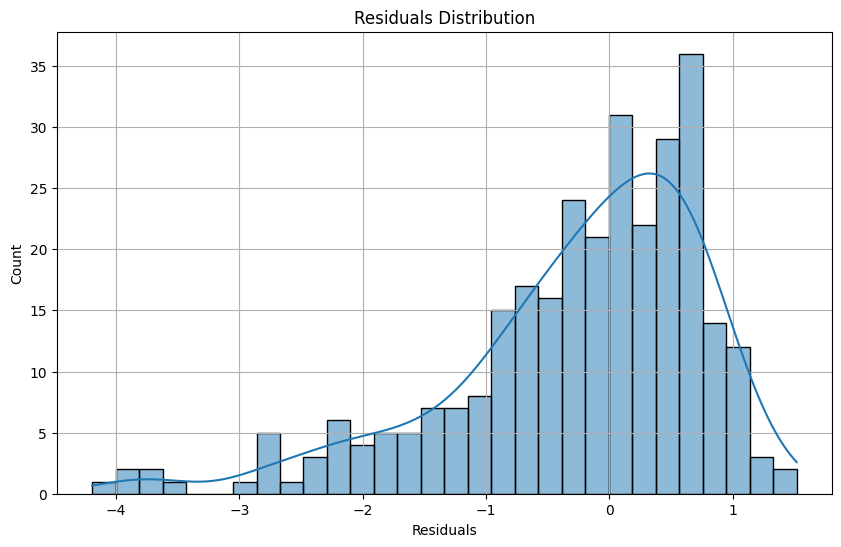

In [15]:
residuals = plot_residuals(y_test, y_pred)

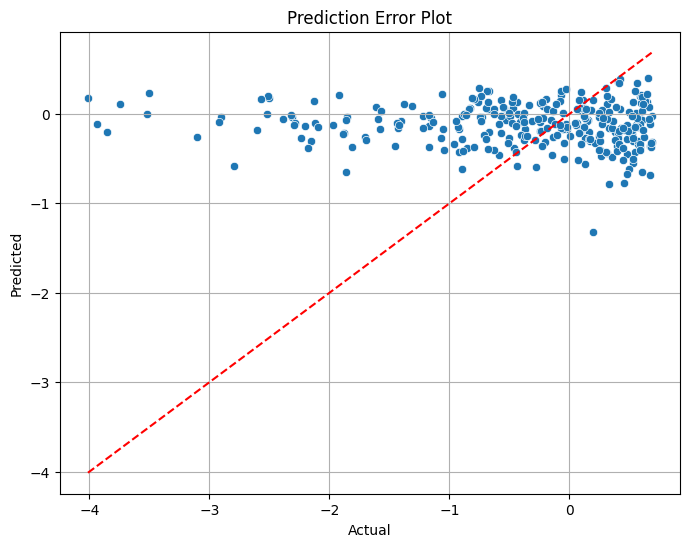

In [16]:
plot_prediction_error(y_test, y_pred)

C:\Users\varun\AppData\Local\Temp\ipykernel_12380\1766843553.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_true, label="Actual", shade=True)
C:\Users\varun\AppData\Local\Temp\ipykernel_12380\1766843553.py:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred, label="Predicted", shade=True)


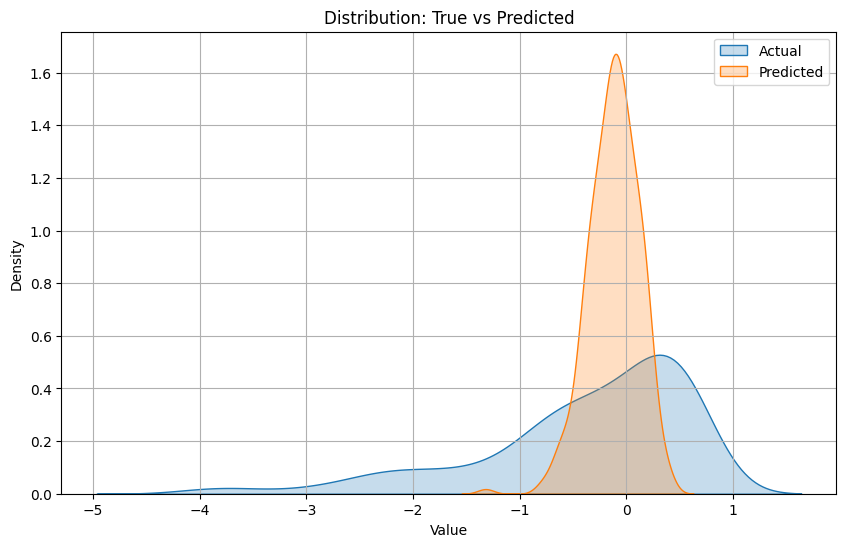

In [17]:
plot_true_vs_pred_distribution(y_test, y_pred)

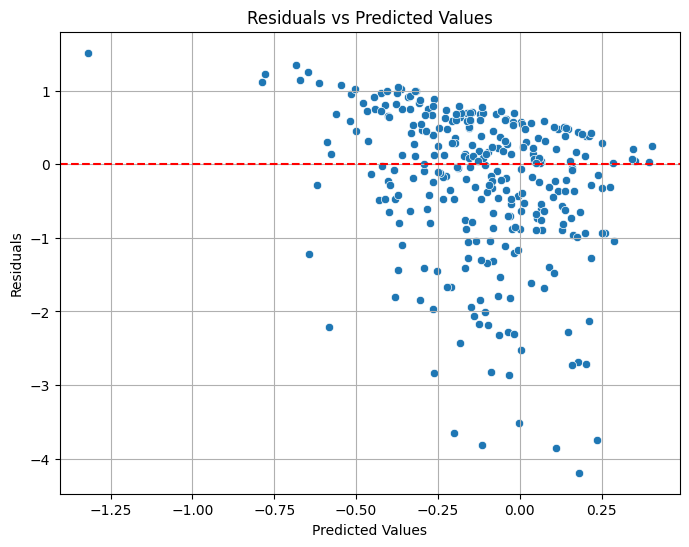

In [18]:
plot_residuals_vs_predicted(y_test, y_pred)

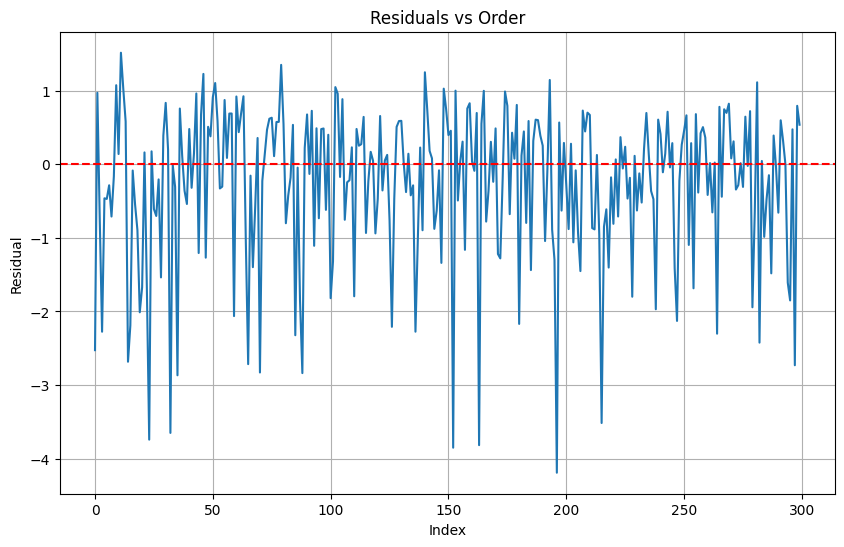

In [19]:
plot_residual_order(y_test, y_pred)

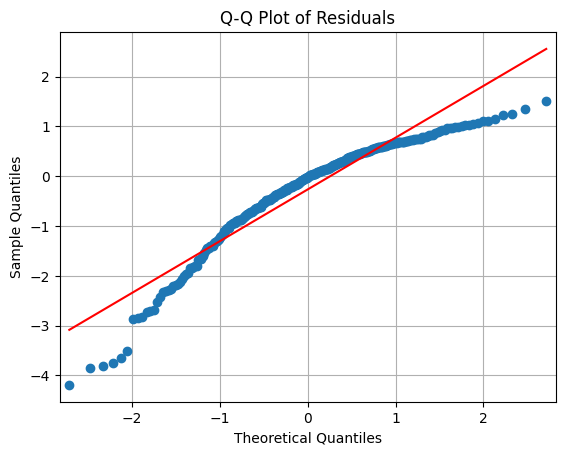

In [20]:
plot_qq(residuals)

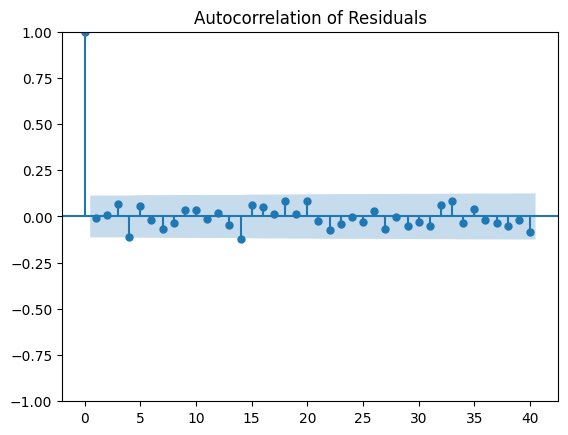

In [21]:
evaluate_autocorrelation(residuals)

In [24]:
outliers, num_outliers = detect_outliers(residuals)
print(f"Number of outliers detected: {num_outliers}")

Number of outliers detected: 6
